In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Step1： 读出来所有基金的数据

In [2]:
import qlib
from qlib.data import D

qlib.init(provider_uri="~/.qlib/qlib_data/cn_fund_data")
df = D.features(D.instruments(market="all"), ["$DWJZ", "$LJJZ"], freq="day")

[18216:MainThread](2021-05-05 13:32:53,331) INFO - qlib.Initialization - [config.py:276] - default_conf: client.
[18216:MainThread](2021-05-05 13:32:53,333) WARNING - qlib.Initialization - [config.py:292] - redis connection failed(host=127.0.0.1 port=6379), cache will not be used!
[18216:MainThread](2021-05-05 13:32:53,812) INFO - qlib.Initialization - [__init__.py:46] - qlib successfully initialized based on client settings.
[18216:MainThread](2021-05-05 13:32:53,812) INFO - qlib.Initialization - [__init__.py:47] - data_path=/Users/wangfan/.qlib/qlib_data/cn_fund_data


In [3]:
df.shape

(9720744, 2)

In [4]:
df.head()

$DWJZ  $LJJZ
instrument datetime                
000001     2005-01-04  0.995  1.115
           2005-01-05  0.998  1.118
           2005-01-06  0.991  1.111
           2005-01-07  0.989  1.109
           2005-01-10  0.992  1.112

In [5]:
df.columns

Index(['$DWJZ', '$LJJZ'], dtype='object')

In [6]:
df = df.reset_index()

In [7]:
df.head()

,instrument,datetime,$DWJZ,$LJJZ
0,000001,2005-01-04,0.995,1.115
1,000001,2005-01-05,0.998,1.118
2,000001,2005-01-06,0.991,1.111
3,000001,2005-01-07,0.989,1.109
4,000001,2005-01-10,0.992,1.112


LJJZ:因此累计净值更能准确地体现一只基金的赚钱能力。

# Step2: 数据加工

In [375]:
df_new = df.copy()

In [376]:
df_new.shape

(9720744, 4)

创建特征

In [377]:
df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(5).agg({'max_5d':'max','min_5d':'min','mean_5d':'mean','std_5d':'std','sum_5d':'sum','median_5d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(20).agg({'max_20d':'max','min_20d':'min','mean_20d':'mean','std_20d':'std','sum_20d':'sum','median_20d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(60).agg({'max_60d':'max','min_60d':'min','mean_60d':'mean','std_60d':'std','sum_60d':'sum','median_60d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(120).agg({'max_120d':'max','min_120d':'min','mean_120d':'mean','std_120d':'std','sum_120d':'sum','median_120d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(240).agg({'max_240d':'max','min_240d':'min','mean_240d':'mean','std_240d':'std','sum_240d':'sum','median_240d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

df_temp = df_new.groupby(['instrument'])["$LJJZ"].rolling(480).agg({'max_480d':'max','min_480d':'min','mean_480d':'mean','std_480d':'std','sum_480d':'sum','median_480d':'median'})
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['instrument','level_1'],axis = 1)
df_new = pd.merge(df_new, df_temp, how = 'inner', left_index=True, right_index=True) 

In [378]:
df_new = df_new.dropna()

In [379]:
df_no_label = df_new.copy()

In [333]:
df_no_label.shape

(4871908, 40)

In [336]:
df_no_label.head()

,instrument,datetime,$DWJZ,$LJJZ,max_5d,min_5d,mean_5d,std_5d,sum_5d,median_5d,...,mean_240d,std_240d,sum_240d,median_240d,max_480d,min_480d,mean_480d,std_480d,sum_480d,median_480d
479,000001,2006-12-26,1.690,2.040,2.053,2.018,2.0372,0.012755,10.186,2.040,...,1.504504,0.249264,361.081,1.5760,2.053,0.979,1.289679,0.279530,619.046001,1.1380
480,000001,2006-12-27,1.719,2.069,2.069,2.018,2.0404,0.018447,10.202,2.040,...,1.508600,0.250432,362.064,1.5790,2.069,0.979,1.291667,0.281669,620.000001,1.1385
481,000001,2006-12-28,1.711,2.061,2.069,2.018,2.0458,0.019993,10.229,2.041,...,1.512692,0.251404,363.046,1.5800,2.069,0.979,1.293631,0.283736,620.943001,1.1395
482,000001,2006-12-29,1.753,2.103,2.103,2.040,2.0628,0.025753,10.314,2.061,...,1.516888,0.252820,364.053,1.5815,2.103,0.979,1.295698,0.286007,621.935001,1.1405
483,000001,2007-01-04,1.753,2.103,2.103,2.040,2.0752,0.027499,10.376,2.069,...,1.521017,0.254268,365.044,1.5830,2.103,0.979,1.297769,0.288242,622.929001,1.1410


创建label

In [380]:
df_new["LJJZ_1d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-1)
df_new["LJJZ_5d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-5)
df_new["LJJZ_20d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-20)
df_new["LJJZ_60d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-60)
df_new["LJJZ_120d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-120)
df_new["LJJZ_240d"] = df_new.groupby(['instrument'])["$LJJZ"].shift(-240)
df_new = df_new.dropna()
df_new.index = range(len(df_new))
df_new["y_1d"]=100 * (df_new["LJJZ_1d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new["y_5d"]=100 * (df_new["LJJZ_5d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new["y_20d"]=100 * (df_new["LJJZ_20d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new["y_60d"]=100 * (df_new["LJJZ_60d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new["y_120d"]=100 * (df_new["LJJZ_120d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new["y_240d"]=100 * (df_new["LJJZ_240d"]- df_new["$LJJZ"])/df_new["$LJJZ"]
df_new = df_new.drop(columns = ['LJJZ_1d','LJJZ_5d','LJJZ_20d','LJJZ_60d','LJJZ_120d','LJJZ_240d'])

In [335]:
df_new.shape

(3624039, 46)

训练集和验证集分离

In [381]:
df_test = df_new[df_new["datetime"] >= "2020-01-01"]
df_train = df_new[df_new["datetime"] < "2020-01-01"]

# Step 3: Modeling
1. linear regression
2. random foreast
3. lightgbm
4. ensemble

In [384]:
train_y_1d = df_train["y_1d"]
train_y_5d = df_train['y_5d']
train_y_20d = df_train['y_20d']
train_y_60d = df_train['y_60d']
train_y_120d = df_train['y_120d']
train_y_240d = df_train['y_240d']

test_y_1d = df_test["y_1d"]
test_y_5d = df_test['y_5d']
test_y_20d = df_test['y_20d']
test_y_60d = df_test['y_60d']
test_y_120d = df_test['y_120d']
test_y_240d = df_test['y_240d']

In [385]:
df_train = df_train.drop(columns = ['datetime','y_1d','y_5d','y_20d','y_60d','y_120d','y_240d'])
df_test = df_test.drop(columns = ['datetime','y_1d','y_5d','y_20d','y_60d','y_120d','y_240d'])

In [386]:
df_train.columns

Index(['instrument', '$DWJZ', '$LJJZ', 'max_5d', 'min_5d', 'mean_5d', 'std_5d',
       'sum_5d', 'median_5d', 'max_20d', 'min_20d', 'mean_20d', 'std_20d',
       'sum_20d', 'median_20d', 'max_60d', 'min_60d', 'mean_60d', 'std_60d',
       'sum_60d', 'median_60d', 'max_120d', 'min_120d', 'mean_120d',
       'std_120d', 'sum_120d', 'median_120d', 'max_240d', 'min_240d',
       'mean_240d', 'std_240d', 'sum_240d', 'median_240d', 'max_480d',
       'min_480d', 'mean_480d', 'std_480d', 'sum_480d', 'median_480d'],
      dtype='object')

In [387]:
train = df_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = df_test.copy()

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)


Training data shape:  (3262682, 39)
Testing data shape:  (361357, 39)


In [344]:
correlations = df_train.corr()

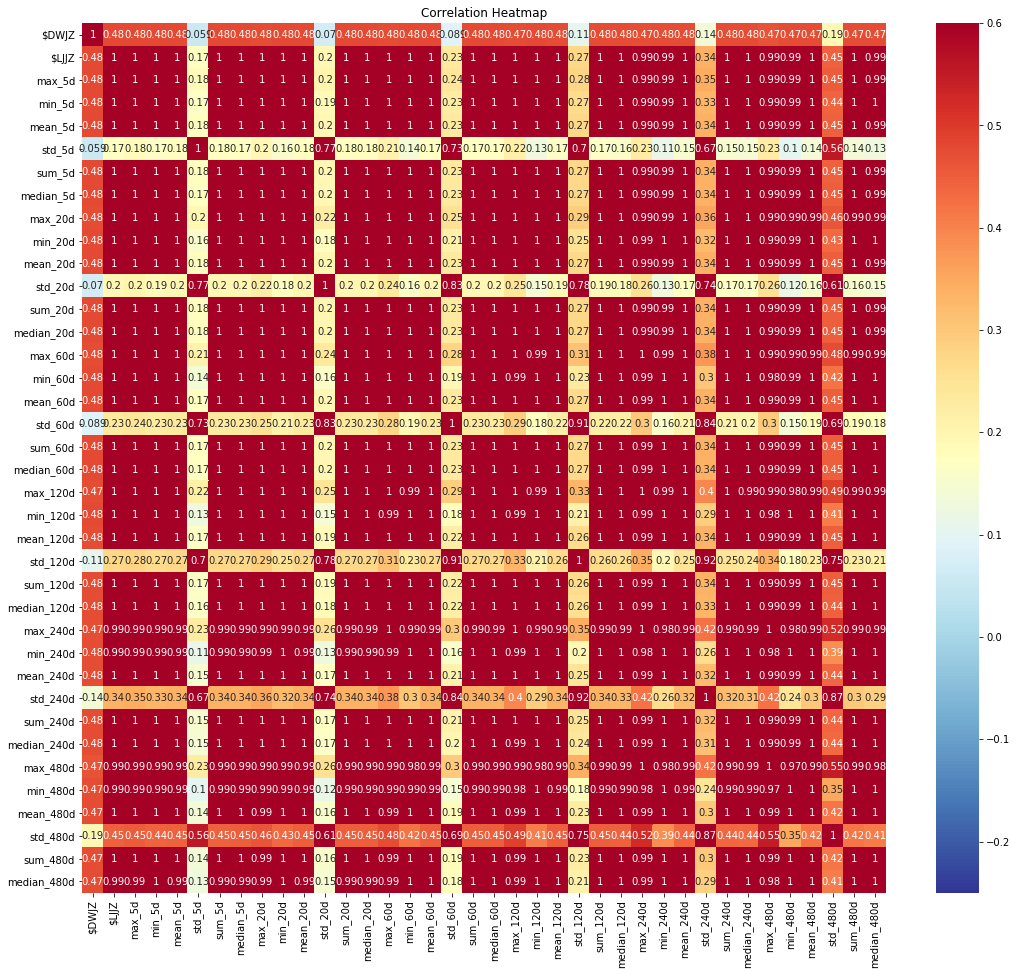

In [345]:
plt.figure(figsize = (18, 16))

# Heatmap of correlations
sns.heatmap(correlations, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [388]:
def train_predict(x_train, y_train, x_test, y_test, name = 'Model', model = 'linear' ):
    if model == 'linear':
        reg = LinearRegression()
    elif model == 'foreast':
        reg = RandomForestRegressor(criterion='mse', n_jobs=-1)
    elif model == 'lightgbm':
        reg =lgb.LGBMRegressor(objective='regression', 
                         num_leaves=4,
                         learning_rate=0.3, 
                         n_estimators=7000,
                         max_bin=300, 
                         bagging_fraction=0.75,
                         bagging_freq=5, 
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1,
                         min_data_in_leaf=2,
                         min_sum_hessian_in_leaf=11)
    else:
        print("Modle name is invalid!")
    
    # Train on the training data
    reg.fit(x_train, y_train)

    # Make predictions
    y_pred = reg.predict(x_test)
    r2 = r2_score(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))

    print(name,": R2 is ", r2, "RMSE is ",rmse)
    print("The prediction is ",y_pred[:5],"...")
    return y_pred

1. linear regression

In [389]:
linear_pre_1d = train_predict(train,train_y_1d,test,test_y_1d,name="Linear regression model 1 day prediction", model = 'linear')

Linear regression model 1 day prediction : R2 is  -253.31892745921007 RMSE is  1.3457666180238936
The prediction is  [0.10860721 0.06380377 0.0881122  0.09582587 0.12005173] ...


In [348]:
linear_pre_5d = train_predict(train,train_y_5d,test,test_y_5d,name="Linear regression model 5 day prediction", model = 'linear')

Linear regression model 5 day prediction : R2 is  -62.06221194938849 RMSE is  2.848613229502369
The prediction is  [0.40860005 0.38563199 0.35828116 0.47943518 0.59288753] ...


In [349]:
linear_pre_20d = train_predict(train,train_y_20d,test,test_y_20d,name="Linear regression model 20 day prediction", model = 'linear')

Linear regression model 20 day prediction : R2 is  -38.33695969917153 RMSE is  5.472142572260568
The prediction is  [1.46021351 1.49808393 1.22736275 1.5448218  1.23049747] ...


In [350]:
linear_pre_60d = train_predict(train,train_y_60d,test,test_y_60d,name="Linear regression model 60 day prediction", model = 'linear')

Linear regression model 60 day prediction : R2 is  -38.3519925788305 RMSE is  12.181752808407445
The prediction is  [1.97837607 1.74667704 1.22741357 1.21362177 0.99383023] ...


In [351]:
linear_pre_120d = train_predict(train,train_y_120d,test,test_y_120d,name="Linear regression model 120 day prediction", model = 'linear')

Linear regression model 120 day prediction : R2 is  -105.8019318922258 RMSE is  21.244824708568174
The prediction is  [5.16288296 4.90154041 4.37402731 4.6588581  4.2136132 ] ...


In [352]:
linear_pre_120d = train_predict(train,train_y_240d,test,test_y_240d,name="Linear regression model 240 day prediction", model = 'linear')

Linear regression model 240 day prediction : R2 is  -36.73407983494669 RMSE is  29.87016774404911
The prediction is  [17.87850292 17.34215563 16.73427274 16.90404188 16.61768255] ...


2.ligthgbm

In [310]:
lightgbm_pre_1d = train_predict(train,train_y_1d,test,test_y_1d,name="lightgbm model 1 day prediction", model = 'lightgbm')

lightgbm model 1 day prediction : R2 is  -12.934171189233986 RMSE is  1.4180092882097226
The prediction is  [0.00874211 0.00145871 0.00044474 0.04418558 0.02986091] ...


In [276]:
lightgbm_pre_5d = train_predict(train,train_y_5d,test,test_y_5d,name="lightgbm model 5 day prediction", model = 'lightgbm')

lightgbm model 5 day prediction : R2 is  0.8991717585683717 RMSE is  0.87732474746302
The prediction is  [0.27239418 0.25818669 0.25699979 0.12854441 0.17018949] ...


In [277]:
lightgbm_pre_20d = train_predict(train,train_y_20d,test,test_y_20d,name="lightgbm model 20 day prediction", model = 'lightgbm')

lightgbm model 20 day prediction : R2 is  0.9176413030987002 RMSE is  1.579733664893963
The prediction is  [0.47169562 0.49791084 0.18223605 0.38572361 0.44191116] ...


In [278]:
lightgbm_pre_60d = train_predict(train,train_y_60d,test,test_y_60d,name="lightgbm model 60 day prediction", model = 'lightgbm')

lightgbm model 60 day prediction : R2 is  0.9558055224062396 RMSE is  2.407638413710533
The prediction is  [-1.19839515 -0.80768913 -0.82191429 -0.75334687 -0.74177049] ...


In [279]:
lightgbm_pre_120d = train_predict(train,train_y_120d,test,test_y_120d,name="lightgbm model 120 day prediction", model = 'lightgbm')

lightgbm model 120 day prediction : R2 is  0.9739690073126668 RMSE is  2.59485260930824
The prediction is  [3.46396068 6.74737416 6.85532949 6.85532949 7.10019189] ...


In [311]:
lightgbm_pre_240d = train_predict(train,train_y_240d,test,test_y_240d,name="lightgbm model 240 day prediction", model = 'lightgbm')

lightgbm model 240 day prediction : R2 is  -4.3326237029231285 RMSE is  28.448320158386437
The prediction is  [-0.09469191 -0.43809421 -0.31434863  0.12130619  2.000263  ] ...


# step4: 预测未来的样本

In [390]:
def train_predict_nolable(x_train, y_train, x_pred, name = 'Model', model = 'linear' ):
    if model == 'linear':
        reg = LinearRegression()
    elif model == 'foreast':
        reg = RandomForestRegressor(criterion='mse', n_jobs=-1)
    elif model == 'lightgbm':
        reg =lgb.LGBMRegressor(objective='regression', 
                         num_leaves=4,
                         learning_rate=0.3, 
                         n_estimators=7000,
                         max_bin=300, 
                         bagging_fraction=0.75,
                         bagging_freq=5, 
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1,
                         min_data_in_leaf=2,
                         min_sum_hessian_in_leaf=11)
    else:
        print("Modle name is invalid!")
    
    # Train on the training data
    reg.fit(x_train, y_train)

    # Make predictions
    y_pred = reg.predict(x_pred)

    print("The prediction is ",y_pred[:5],"...")
    return y_pred

In [416]:
df_pre = df_no_label[df_no_label['datetime'] == '2021-04-30']
df_pre = df_pre.drop(columns = ['datetime'])
no_label = scaler.transform(df_pre)
print('Nolabel data shape: ', no_label.shape)

Nolabel data shape:  (5609, 39)


In [434]:
train.shape

(3262682, 39)

In [435]:
df_pre.shape

(5609, 41)

In [436]:
y_pred = train_predict_nolable(train, train_y_1d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_1d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_pre, df, how = 'inner', left_index=True, right_index=True) 

The prediction is  [-0.09435811 -0.07078068 -0.0281368   0.08796644  0.01159243] ...


In [437]:
y_pred = train_predict_nolable(train, train_y_5d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_5d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_result, df, how = 'inner', left_index=True, right_index=True) 

The prediction is  [-0.18216154 -0.33843556 -0.28852127 -0.16651992 -0.11941617] ...


In [438]:
y_pred = train_predict_nolable(train, train_y_20d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_20d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_result, df, how = 'inner', left_index=True, right_index=True) 

The prediction is  [-1.66515482  1.55743586  1.91176204  0.30647682 -1.58154173] ...


In [439]:
y_pred = train_predict_nolable(train, train_y_60d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_60d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_result, df, how = 'inner', left_index=True, right_index=True) 

The prediction is  [-6.45271048 -7.23395615 -5.90156657 -0.93038609 -4.31229246] ...


In [440]:
y_pred = train_predict_nolable(train, train_y_120d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_120d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_result, df, how = 'inner', left_index=True, right_index=True) 

The prediction is  [ -7.202398   -12.042601   -10.4462103   13.77811639  -3.38516008] ...


In [441]:
y_pred = train_predict_nolable(train, train_y_240d, no_label, name = 'Model', model = 'lightgbm' )
df = pd.DataFrame({'pred_240d':y_pred})
df = df.reset_index()
df_result = pd.merge(df_result, df, how = 'inner', left_index=True, right_index=True) 

The prediction is  [-4.96855189 13.40848073 18.9261143   8.89351809  6.16719096] ...


In [442]:
df_result = df_result[['instrument','pred_1d','pred_5d','pred_20d','pred_60d','pred_120d','pred_240d']]

In [447]:
df_result[df_result['instrument']=='502056']

,instrument,pred_1d,pred_5d,pred_20d,pred_60d,pred_120d,pred_240d
5043,502056,-0.24801,-0.788986,-1.542662,1.339101,3.135561,18.421594


| 基金名称 | 基金号码  | 持仓金额 | 成本 
| :-----| ----: | :----: | :----: |
| 中欧医疗健康混合C | 003096 | 5521 | 5000
| 中欧时代先锋股票A | 001938 | 335 |
| 广发多因子混合 | 002943 | 6147 |
| 广发纳斯达克100指数A | 270042 | 3065 | 3000
| 广发中证医疗指数(LOF)A | 502056 | 1000 | 1000
| 广发高端制造股票A( | 004997 | 1946 | 2000
| 景顺长城鼎益混合(LOF) | 162605 | 3175 | 3000
| 景顺长城新兴成长混合 | 260108 | 2719 | 2740
| 景顺长城优选混合 | 260101 | 2019 |
| 国富弹性市值混合 | 450002 | 13380 |
| 银华富裕主题混合 | 180012 | 2251 |
| 南方优选成长混合A | 202023 | 1022 |
| 南方中证全指证券公司ETF联接C | 004070 | 391 | 400
| 兴全合润混合(LOF) | 163406 | 4000 | 4000
| 兴全合宜混合(LOF)A | 163417 | 2034 |
| 兴全趋势投资混合(LOF) | 163402 | 1031 |
| 大成高新技术产业股票A | 00628 | 991 | 1000
| 大成新锐产业混合 | 090018 | 1006 | 1000
| 天弘中证500指数增强C | 001557 | 1000 | 1000
| 天弘中证银行ETF联接C | 001595 | 966 | 1000
| 工银战略远见混合C | 011933 | 1000 | 1000
| 方正富邦保险主题指数 | 167301 | 191 | 200
| 华夏中证500ETF联接A | 001052 | 1043 |
| 嘉实智能汽车股票 | 002168 | 1045 | 1000
| 信达澳银新能源产业股票 | 001410 | 672 |





In [448]:
df_result[df_result['instrument']=='450002']

,instrument,pred_1d,pred_5d,pred_20d,pred_60d,pred_120d,pred_240d
4914,450002,-0.008714,0.168311,-1.581886,-3.285281,-9.06242,-1.528047


In [449]:
df_result.to_csv('20210430.csv')